In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWW"
offset_url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWWa&offset={}"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}
movies_data = []
page_urls = [base_url] + [offset_url.format(offset) for offset in range(200, 1000, 200)]
for page_num, url in enumerate(page_urls, start=1):
    #print(f"\nScraping Page {page_num}: {url}\n")
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve page {page_num}")
        continue  
    soup = BeautifulSoup(response.text,"html.parser")
    rows = soup.select("tr")[1:] 
    for row in rows:
        try:
            title = row.select_one("td a").text.strip()
            gross = row.select("td")[2].text.strip()
            release_year = row.select("td")[3].text.strip()
            
            # Append data to list
            movies_data.append([title, gross, release_year])
        except AttributeError:
            continue  # Skip invalid rows
    
    # Add a delay to avoid getting blocked
    time.sleep(2)
df = pd.DataFrame(movies_data, columns=["Title", "Gross Revenue", "Release Year"])

In [3]:
df.head()

,Title,Gross Revenue,Release Year
0,Avatar,"$2,923,710,708",2009
1,Avengers: Endgame,"$2,799,439,100",2019
2,Avatar: The Way of Water,"$2,320,250,281",2022
3,Titanic,"$2,264,812,968",1997
4,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218",2015


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1000 non-null   object
 1   Gross Revenue  1000 non-null   object
 2   Release Year   1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


## coverting data-types

In [6]:
df['Release Year'] = pd.to_datetime(df['Release Year']).dt.year

In [7]:
df['Gross Revenue'] = df['Gross Revenue'].replace('[/$,]', '', regex=True).astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          1000 non-null   object 
 1   Gross Revenue  1000 non-null   float64
 2   Release Year   1000 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 19.7+ KB


In [9]:
df.head()

,Title,Gross Revenue,Release Year
0,Avatar,2.923711e+09,2009
1,Avengers: Endgame,2.799439e+09,2019
2,Avatar: The Way of Water,2.320250e+09,2022
3,Titanic,2.264813e+09,1997
4,Star Wars: Episode VII - The Force Awakens,2.071310e+09,2015


In [10]:
df.groupby('Release Year').agg({"Gross Revenue":"sum"})

,Gross Revenue
Release Year,
1937,1.849255e+08
1939,2.008822e+08
1942,1.022472e+08
1950,9.314115e+07
1953,8.740465e+07
...,...
2021,7.903538e+09
2022,1.160157e+10
2023,1.112271e+10


In [11]:
#df.to_csv("Life_time_grosses_BOX_OFFICE.csv",index=False)

In [12]:
#cheking for null values
df.isnull().sum()

Title            0
Gross Revenue    0
Release Year     0
dtype: int64

## Top 20 movies all time based on Gross Revenue

In [13]:
top_20 = df.nlargest(20, "Gross Revenue")
print(top_20)

                                         Title  Gross Revenue  Release Year
0                                       Avatar   2.923711e+09          2009
1                            Avengers: Endgame   2.799439e+09          2019
2                     Avatar: The Way of Water   2.320250e+09          2022
3                                      Titanic   2.264813e+09          1997
4   Star Wars: Episode VII - The Force Awakens   2.071310e+09          2015
5                       Avengers: Infinity War   2.052415e+09          2018
6                      Spider-Man: No Way Home   1.921408e+09          2021
7                                     Ne Zha 2   1.895832e+09          2025
8                                 Inside Out 2   1.698864e+09          2024
9                               Jurassic World   1.671537e+09          2015
10                               The Lion King   1.662021e+09          2019
11                                The Avengers   1.520539e+09          2012
12          

In [14]:
df['Decade'] = (df['Release Year']//10)*10

In [15]:
top_per_decade = df.loc[df.groupby("Decade")["Gross Revenue"].idxmax(), ["Decade", "Title", "Gross Revenue"]]

In [16]:
top_per_decade

,Decade,Title,Gross Revenue
243,1930,Gone with the Wind,2.008822e+08
794,1940,Bambi,1.022472e+08
898,1950,Lady and the Tramp,9.360233e+07
388,1960,The Sound of Music,1.592875e+08
116,1970,Star Wars: Episode IV - A New Hope,7.753985e+08
107,1980,E.T. the Extra-Terrestrial,7.973074e+08
3,1990,Titanic,2.264813e+09
0,2000,Avatar,2.923711e+09
1,2010,Avengers: Endgame,2.799439e+09
2,2020,Avatar: The Way of Water,2.320250e+09


In [17]:
'''
Category	Revenue (in million $)
## Blockbuster	≥ 1,000M (≥ $1B)
## Super Hit	500M – 999M
## Hit	250M – 499M
## Average	100M – 249M
## Flop	< 100M '''

'\nCategory\tRevenue (in million $)\n## Blockbuster\t≥ 1,000M (≥ $1B)\n## Super Hit\t500M – 999M\n## Hit\t250M – 499M\n## Average\t100M – 249M\n## Flop\t< 100M '

In [18]:
def category(revenue):
    if revenue >= 1_000_000_000:  # 1 billion
        return "Blockbuster"
    elif revenue >= 500_000_000:  # 500 million
        return "Super Hit"
    elif revenue >= 250_000_000:  # 250 million
        return "Hit"
    elif revenue >= 100_000_000:  # 100 million
        return "Average"
    else:
        return "Flop"

In [19]:
df["Category"] = df["Gross Revenue"].apply(category)

In [20]:
df

,Title,Gross Revenue,Release Year,Decade,Category
0,Avatar,2.923711e+09,2009,2000,Blockbuster
1,Avengers: Endgame,2.799439e+09,2019,2010,Blockbuster
2,Avatar: The Way of Water,2.320250e+09,2022,2020,Blockbuster
3,Titanic,2.264813e+09,1997,1990,Blockbuster
4,Star Wars: Episode VII - The Force Awakens,2.071310e+09,2015,2010,Blockbuster
...,...,...,...,...,...
995,Alita: Battle Angel,8.583821e+07,2019,2010,Flop
996,Fury,8.581791e+07,2014,2010,Flop
997,Pokémon: The First Movie - Mewtwo Strikes Back,8.574466e+07,1999,1990,Flop
998,Real Steel,8.546851e+07,2011,2010,Flop


In [21]:
category_count = df["Category"].value_counts()

In [22]:
category_count

Category
Average        646
Flop           154
Super Hit      143
Blockbuster     57
Name: count, dtype: int64

## find out most floped movies all time

In [24]:
flop_movies = df[df["Category"] == "Flop"].sort_values(by = "Gross Revenue",ascending=True).head(10)
flop_movies[["Title", "Gross Revenue", "Release Year"]]

,Title,Gross Revenue,Release Year
999,The SpongeBob SquarePants Movie,85417988.0,2004
998,Real Steel,85468508.0,2011
997,Pokémon: The First Movie - Mewtwo Strikes Back,85744662.0,1999
996,Fury,85817906.0,2014
995,Alita: Battle Angel,85838210.0,2019
994,Spy Kids 2: Island of Lost Dreams,85846429.0,2002
993,Alvin and the Chipmunks: The Road Chip,85886987.0,2015
992,Die Hard,85892546.0,1988
991,Annie,85911262.0,2014
990,Mean Girls,86058055.0,2004


## find out top10 block bluester movies

In [26]:
block_blusters = df[df["Category"]=="Blockbuster"].sort_values(by = "Gross Revenue",ascending=False).head(10)
block_blusters[["Title", "Gross Revenue", "Release Year"]]

,Title,Gross Revenue,Release Year
0,Avatar,2.923711e+09,2009
1,Avengers: Endgame,2.799439e+09,2019
2,Avatar: The Way of Water,2.320250e+09,2022
3,Titanic,2.264813e+09,1997
4,Star Wars: Episode VII - The Force Awakens,2.071310e+09,2015
5,Avengers: Infinity War,2.052415e+09,2018
6,Spider-Man: No Way Home,1.921408e+09,2021
7,Ne Zha 2,1.895832e+09,2025
8,Inside Out 2,1.698864e+09,2024
9,Jurassic World,1.671537e+09,2015


## find out top 5 super-hit movies

In [28]:
top_5_superhit_movies = df[df["Category"]=="Super Hit"].sort_values(by = "Gross Revenue",ascending=False).head(5)
top_5_superhit_movies[["Title","Gross Revenue","Release Year"]]

,Title,Gross Revenue,Release Year
57,The Lion King,979161373.0,1994
58,Oppenheimer,975811333.0,2023
59,Harry Potter and the Deathly Hallows: Part 1,974919063.0,2010
60,Despicable Me 2,970766005.0,2013
61,Despicable Me 4,969126452.0,2024


## find out top 5 Average movies

In [30]:
top5_avg_movies = df[df["Category"] =="Average"].sort_values(by = "Gross Revenue",ascending =False).head(5)
top5_avg_movies[["Title","Gross Revenue","Release Year"]]

,Title,Gross Revenue,Release Year
200,King Kong,218080025.0,2005
201,Ghost,217631306.0,1990
202,How to Train Your Dragon,217581231.0,2010
203,The Da Vinci Code,217536138.0,2006
204,Aladdin,217350219.0,1992


## Find the top movie for each year based on Gross Revenue.

In [32]:
top_per_year = df.loc[df.groupby("Release Year")["Gross Revenue"].idxmax()]
top_per_year[["Title","Release Year","Decade"]]

,Title,Release Year,Decade
279,Snow White and the Seven Dwarfs,1937,1930
243,Gone with the Wind,1939,1930
794,Bambi,1942,1940
907,Cinderella,1950,1950
972,Peter Pan,1953,1950
...,...,...,...
6,Spider-Man: No Way Home,2021,2020
2,Avatar: The Way of Water,2022,2020
15,Barbie,2023,2020
8,Inside Out 2,2024,2020


## Number of Movies Released Per Decade

In [34]:
no_of_movie_releasd_per_decade = df['Decade'].value_counts().sort_index()
no_of_movie_releasd_per_decade

Decade
1930      2
1940      1
1950      3
1960      7
1970     21
1980     50
1990    145
2000    281
2010    384
2020    106
Name: count, dtype: int64

## Revenue Trend Over Time

In [36]:
revenue_trend = df.groupby("Release Year").agg({"Gross Revenue":"mean"})
revenue_trend

,Gross Revenue
Release Year,
1937,1.849255e+08
1939,2.008822e+08
1942,1.022472e+08
1950,9.314115e+07
1953,8.740465e+07
...,...
2021,3.763589e+08
2022,4.833987e+08
2023,3.475846e+08


# visualization

## Top 20 Movies Based on Gross Revenue

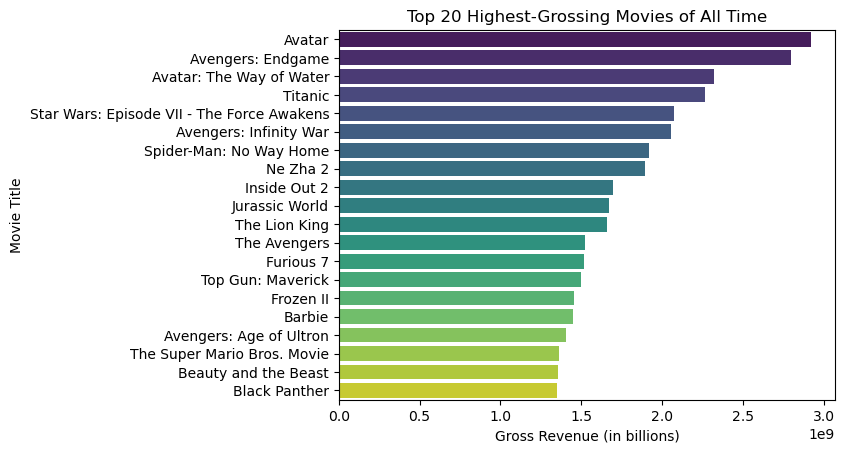

In [38]:

sns.barplot(data = top_20,x="Gross Revenue", y="Title",palette="viridis",hue = "Title")
plt.xlabel("Gross Revenue (in billions)")
plt.ylabel("Movie Title")
plt.title("Top 20 Highest-Grossing Movies of All Time")
plt.show()

 ## Top Movie Per Decade (Revenue)

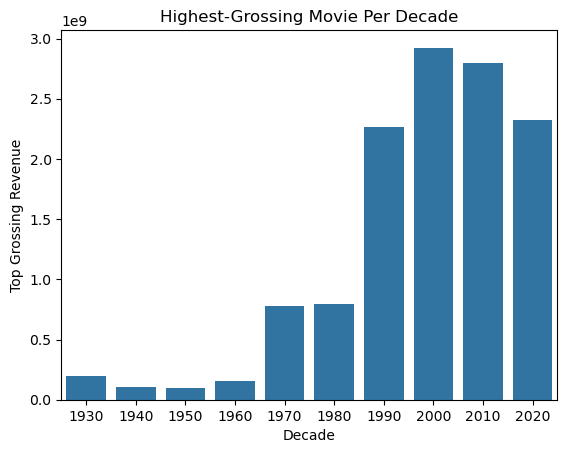

In [40]:
sns.barplot(data =top_per_decade,x = "Decade",y ="Gross Revenue" )
plt.xlabel("Decade")
plt.ylabel("Top Grossing Revenue")
plt.title("Highest-Grossing Movie Per Decade")
plt.show()

## Movie Category Distribution

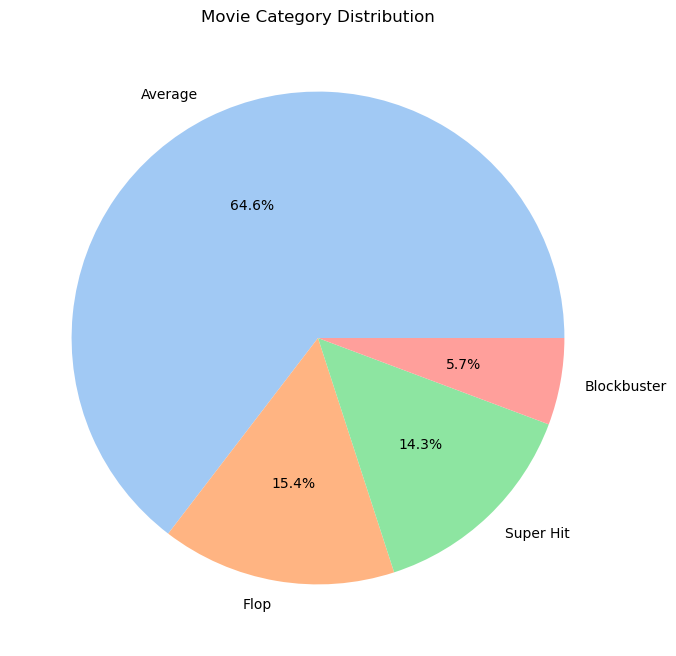

In [42]:
plt.figure(figsize=(8, 8))
plt.pie(category_count,labels=category_count.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Movie Category Distribution")
plt.show()

## Most Flopped Movies

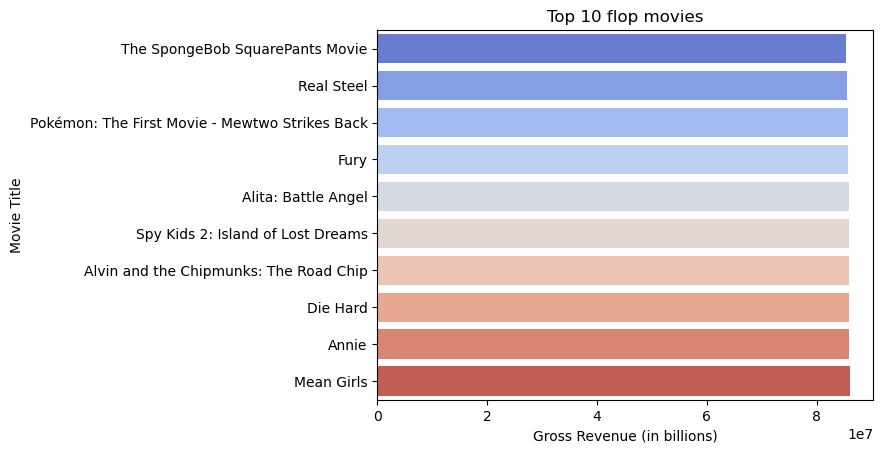

In [44]:
sns.barplot(data =flop_movies,y= "Title",x = "Gross Revenue", palette="coolwarm",hue ="Title")
plt.xlabel("Gross Revenue (in billions)")
plt.ylabel("Movie Title")
plt.title("Top 10 flop movies")
plt.show()


## find out top10 block bluester movies

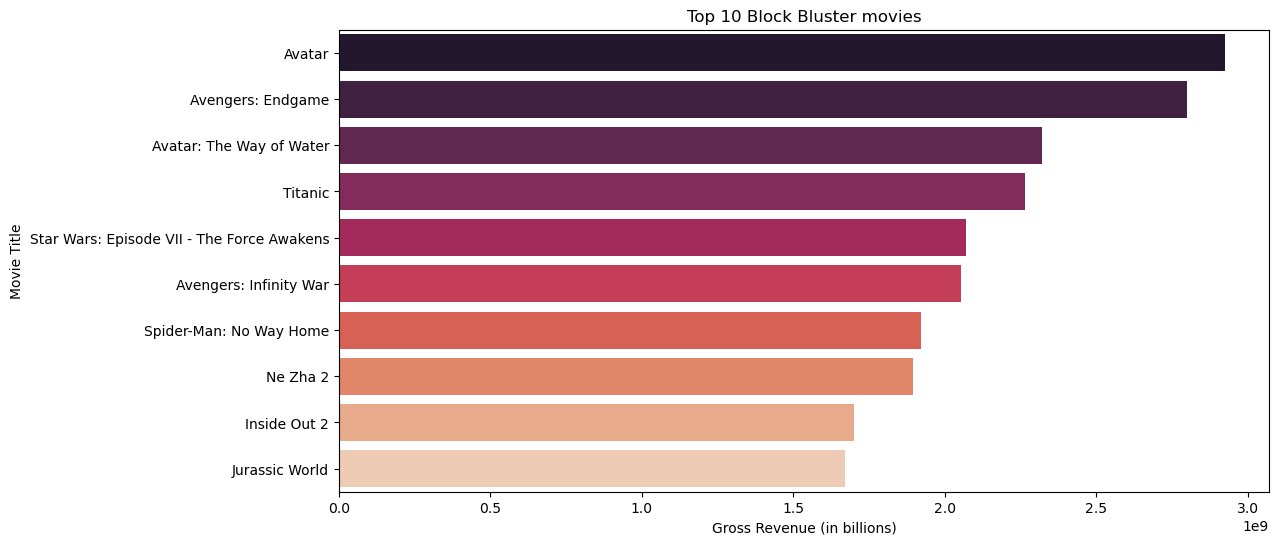

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(data = block_blusters,x = "Gross Revenue", y = "Title", palette="rocket",hue = "Title")
plt.xlabel("Gross Revenue (in billions)")
plt.ylabel("Movie Title")
plt.title("Top 10 Block Bluster movies")
plt.show()

## Revenue Trend Over Years 

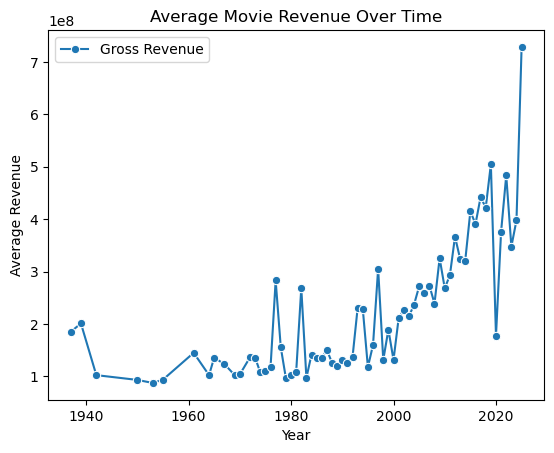

In [48]:
sns.lineplot(data  = revenue_trend,marker = "o")
plt.xlabel("Year")
plt.ylabel("Average Revenue")
plt.title("Average Movie Revenue Over Time")
plt.show()

## Number of Movies Released Per Decade 

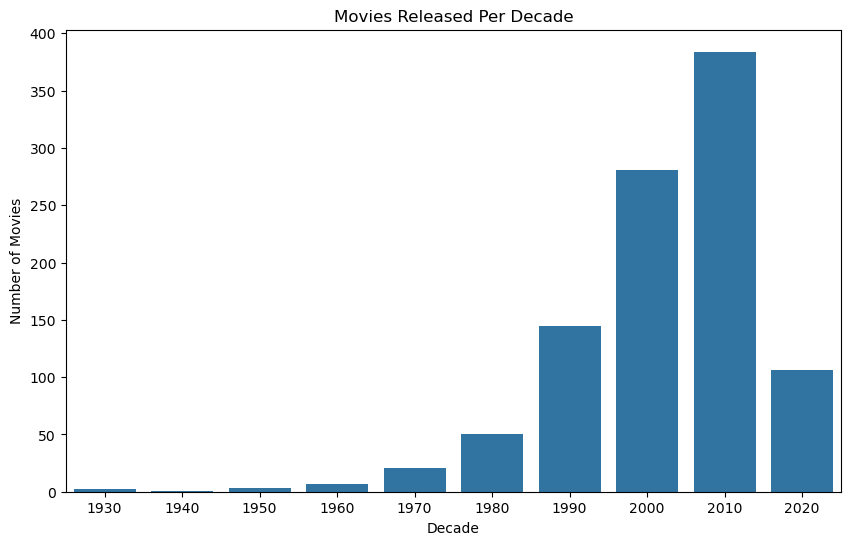

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(x=no_of_movie_releasd_per_decade.index, y=no_of_movie_releasd_per_decade.values)
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.title("Movies Released Per Decade")
plt.show()

## Top 5 Super-Hit Movies

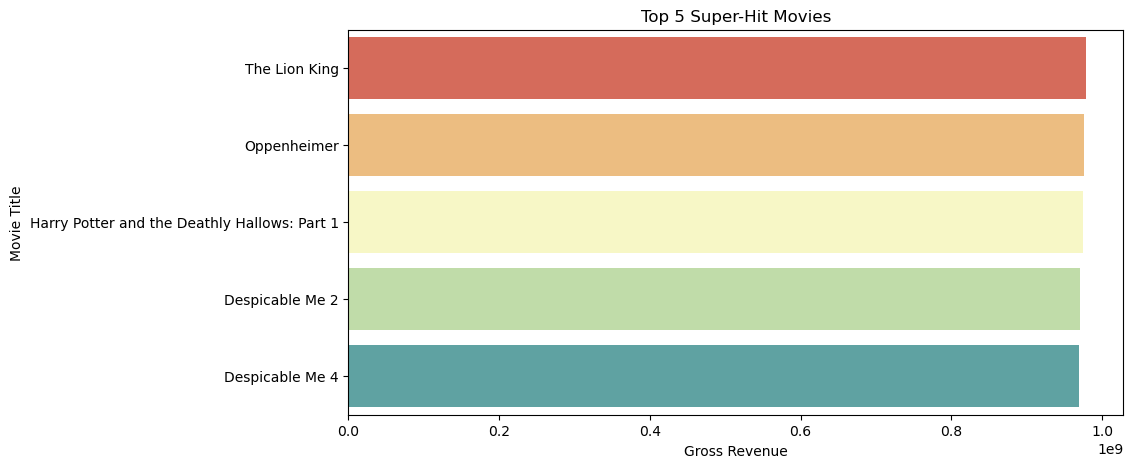

In [51]:
plt.figure(figsize=(10, 5))
sns.barplot(data=top_5_superhit_movies, x="Gross Revenue", y="Title", palette="Spectral",hue = "Title")
plt.xlabel("Gross Revenue")
plt.ylabel("Movie Title")
plt.title("Top 5 Super-Hit Movies")
plt.show()

## Top5 Average movie

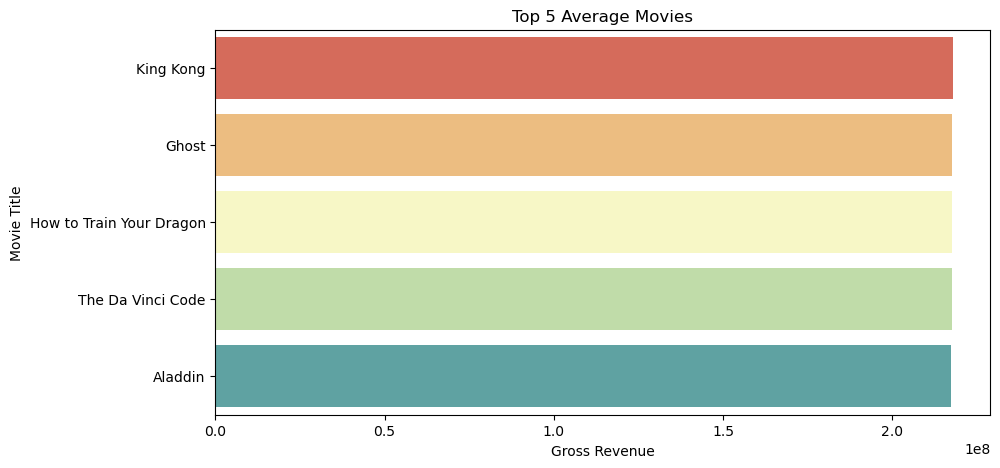

In [53]:
plt.figure(figsize=(10, 5))
sns.barplot(data = top5_avg_movies,x = "Gross Revenue", y = "Title",palette="Spectral",hue = "Title")
plt.xlabel("Gross Revenue")
plt.ylabel("Movie Title")
plt.title("Top 5 Average Movies")
plt.show()

## Conclusion:

"Avatar" stands as the highest-grossing movie of all time, with a massive box office collection of $2,923,710,708. In contrast, "The SpongeBob SquarePants Movie" had the lowest earnings, generating only $85,417,988.

When analyzing movie distribution, only 5.7% (approximately 6%) of films achieved blockbuster status. The 2000s emerged as the decade with the highest total gross revenue, while the average movie revenue saw a significant surge.

Finally, the year 2010 recorded the highest number of movie releases